In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


In [2]:
df = pd.read_csv('./전기차분류.csv')

데이터 전처리

In [3]:
# 필요한 컬럼 선택
df = df[['배기량', '연비', '차종']]

# 컬럼명 바꾸기
df.columns = ['engine_cc', 'fuel_efficiency', 'vehicle_type']

# 데이터 타입 변환
df['engine_cc'] = pd.to_numeric(df['engine_cc'], errors='coerce')
df['fuel_efficiency'] = pd.to_numeric(df['fuel_efficiency'], errors='coerce')

In [4]:
df.isnull().sum()   #결측치 없음

engine_cc          0
fuel_efficiency    0
vehicle_type       0
dtype: int64

라벨 인코딩

In [5]:
# 일반 -> 0
# 하이브리드 -> 1

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['vehicle_type_encoded'] = le.fit_transform(df['vehicle_type'])

동력유형에 따른 차종 파일 불러오기

In [7]:
# 🔹 차종 목록 파일 불러오기
car_df = pd.read_csv('./동력유형에 따른 차종분류.csv')

In [8]:
car_df.head()

,동력유형,차종
0,하이브리드,아이오닉 하이브리드
1,일반,K5
2,일반,싼타페
3,일반,그랜저HG
4,일반,모닝


In [9]:
vehicle_table = (
    car_df
    .groupby('동력유형')['차종']
    .apply(list)
    .to_dict()
)

상관계수 구하기

In [10]:
corr = df[['engine_cc','fuel_efficiency','vehicle_type_encoded']].corr()
print(corr)

                      engine_cc  fuel_efficiency  vehicle_type_encoded
engine_cc              1.000000         0.658277             -0.328189
fuel_efficiency        0.658277         1.000000              0.149833
vehicle_type_encoded  -0.328189         0.149833              1.000000


In [11]:
# 상관분석 결과 배기량과 연비 사이에는 음의 상관관계가 나타났으며,
# 연비는 차량 유형 분류에 중요한 변수임을 확인함.

데이터 분포 시각화

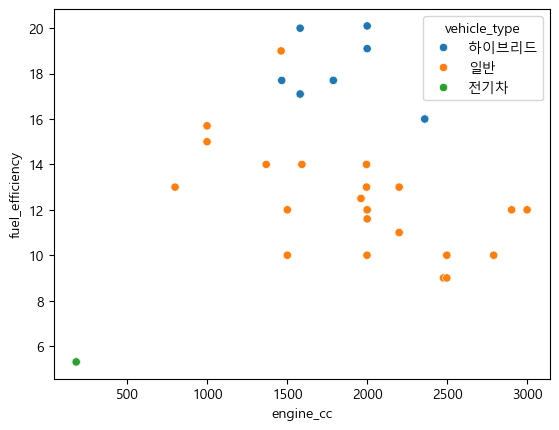

In [12]:
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic' # 윈도우
plt.rcParams['axes.unicode_minus'] = False

sns.scatterplot(
    data=df,
    x='engine_cc',
    y='fuel_efficiency',
    hue='vehicle_type'
)
plt.show()

In [13]:
# 하이브리드 차량은 상대적으로 연비가 높고
# 일반 차량은 배기량이 큰 경향

Feature / Target 분리

In [14]:
X = df[['engine_cc','fuel_efficiency']]
y = df['vehicle_type_encoded']

학습 / 테스트 데이터 분리

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [16]:
# 로지스틱회귀는 선형 결정 경계를 가지며 해석이 용이하다는 장점이 있다.
# 반면 KNN은 비선형 분류가 가능하나, 데이터 수와 스케일에 민감하다.
# 본 데이터셋에서는 두 모델의 성능을 비교하여 데이터 특성에 따른 모델 차이를 분석하였다.

KNN을 위한 스케일링

In [17]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# KNN 모델은 거리 기반 알고리즘이므로 
# 변수 간 스케일 차이를 보정하기 위해 표준화

모델 1 : 로지스틱 회귀

In [19]:
lr_scaled = LogisticRegression()
lr_scaled.fit(X_train_scaled, y_train)

y_pred_lr_scaled = lr_scaled.predict(X_test_scaled)
acc_lr_scaled = accuracy_score(y_test, y_pred_lr_scaled)

print("Logistic Regression (Scaled) Accuracy:", acc_lr_scaled)

Logistic Regression (Scaled) Accuracy: 0.9375


In [20]:
from sklearn.metrics import classification_report

print("LR Classification Report")
print(classification_report(y_test, y_pred_lr_scaled))

LR Classification Report
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      1.00      1.00         6
           2       1.00      0.67      0.80         3

    accuracy                           0.94        16
   macro avg       0.96      0.89      0.91        16
weighted avg       0.95      0.94      0.93        16



c:\Users\User\.conda\envs\ml_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


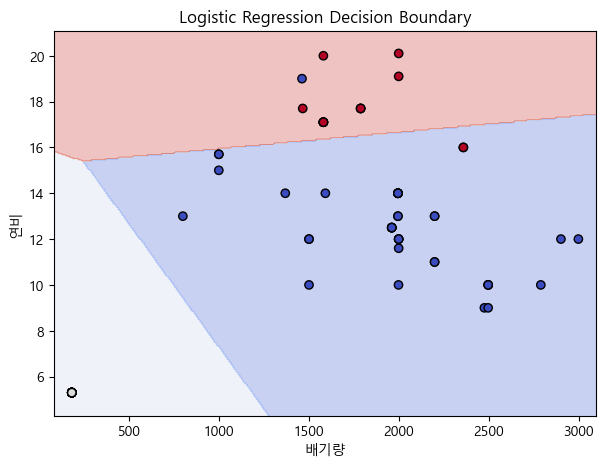

In [21]:
# 결정 경계 시각화용 그리드 생성
x_min, x_max = X['engine_cc'].min() - 100, X['engine_cc'].max() + 100
y_min, y_max = X['fuel_efficiency'].min() - 1, X['fuel_efficiency'].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

# Logistic Regression 예측
grid_scaled = scaler.transform(np.c_[xx.ravel(), yy.ravel()])
Z_lr = lr_scaled.predict(grid_scaled)
Z_lr = Z_lr.reshape(xx.shape)


# 시각화
plt.figure(figsize=(7,5))
plt.contourf(xx, yy, Z_lr, alpha=0.3, cmap='coolwarm')

plt.scatter(
    X['engine_cc'],
    X['fuel_efficiency'],
    c=y,
    edgecolors='k',
    cmap='coolwarm'
)

plt.xlabel("배기량")
plt.ylabel("연비")
plt.title("Logistic Regression Decision Boundary")
plt.show()


In [22]:
# 배경색 : 모델이 영역을 구분한 것
# 경계선 : 확률 0.5 기준선
# 점 : 실제 데이터

모델 2 : KNN

In [23]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)
acc_knn = accuracy_score(y_test, y_pred_knn)

print("KNN Accuracy:", acc_knn)

KNN Accuracy: 0.9375


c:\Users\User\.conda\envs\ml_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


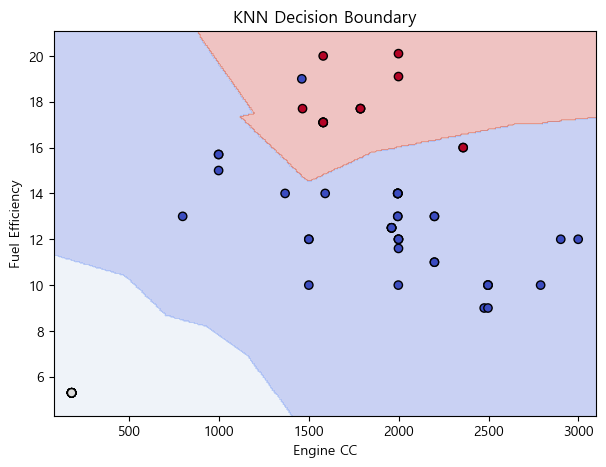

In [24]:
# KNN 결정 경계
Z_knn = knn.predict(scaler.transform(np.c_[xx.ravel(), yy.ravel()]))
Z_knn = Z_knn.reshape(xx.shape)

plt.figure(figsize=(7,5))
plt.contourf(xx, yy, Z_knn, alpha=0.3, cmap='coolwarm')

plt.scatter(
    X['engine_cc'],
    X['fuel_efficiency'],
    c=y,
    edgecolors='k',
    cmap='coolwarm'
)

plt.xlabel("Engine CC")
plt.ylabel("Fuel Efficiency")
plt.title("KNN Decision Boundary")
plt.show()


In [25]:
print("KNN Classification Report")
print(classification_report(y_test, y_pred_knn))

KNN Classification Report
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      1.00      1.00         6
           2       1.00      0.67      0.80         3

    accuracy                           0.94        16
   macro avg       0.96      0.89      0.91        16
weighted avg       0.95      0.94      0.93        16



c:\Users\User\.conda\envs\ml_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


예측 동력 유형: 일반
해당 유형 대표 차종: ['K3', 'K5', 'QM3', 'QM5', 'SM5', '그랜드 스타렉스', '그랜저HG', '모닝', '모하비', '봉고', '비스토', '스타렉스', '스타리아', '싼타페', '쏘렌토', '아반떼', '엑센트', '올뉴카니발', '카니발', '투싼', '포터']


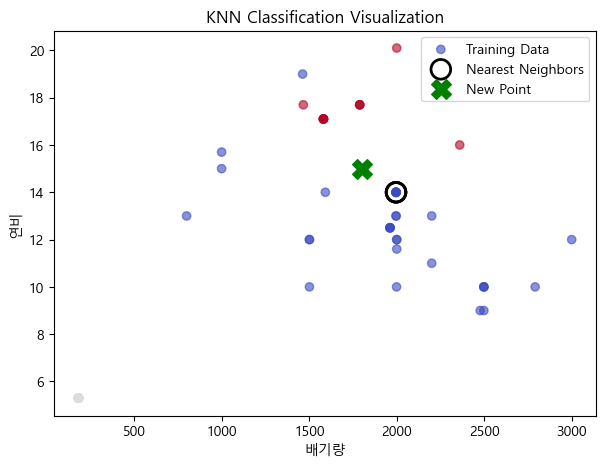

In [26]:
# 새로운 데이터 하나 던져보기 (가상의 차량)
new_point = np.array([[1800, 15]])  # 배기량 1800, 연비 15

# 스케일링 (KNN은 스케일링 필수)
new_point_scaled = scaler.transform(new_point)


pred = knn.predict(new_point_scaled)[0]

# 숫자 → 한글 라벨 변환
pred_label = le.inverse_transform([pred])[0]

# 차종 목록 중복 제거
unique_models = sorted(set(vehicle_table[pred_label]))

# 출력
print("예측 동력 유형:", pred_label)
print("해당 유형 대표 차종:", unique_models)


# KNN에서 가장 가까운 이웃 찾기
distances, indices = knn.kneighbors(new_point_scaled)

# 시각화
plt.figure(figsize=(7,5))

# 전체 데이터
plt.scatter(
    X_train['engine_cc'],
    X_train['fuel_efficiency'],
    c=y_train,
    cmap='coolwarm',
    alpha=0.6,
    label='Training Data'
)

# 이웃 데이터 강조
neighbors = X_train.iloc[indices[0]]
plt.scatter(
    neighbors['engine_cc'],
    neighbors['fuel_efficiency'],
    s=200,
    facecolors='none',
    edgecolors='black',
    linewidths=2,
    label='Nearest Neighbors'
)

# 새로운 점 a
plt.scatter(
    new_point[0][0],
    new_point[0][1],
    color='green',
    s=200,
    marker='X',
    label='New Point'
)

plt.xlabel("배기량")
plt.ylabel("연비")
plt.title("KNN Classification Visualization")
plt.legend()
plt.show()


In [27]:
# 위 시각화에서는 임의의 차량 데이터를 입력했을 때
# 가장 가까운 이웃들이 동일한 차량 유형으로 분포되어 있어
# 해당 클래스(일반)로 분류됨을 직관적으로 확인할 수 있다.

앙상블

In [28]:
# 단일 모델의 약점을 보완하기 위해 앙상블 기법 적용
# 현재 데이터 규모와 이해도를 고려해 해석이 쉬운 Voting 방식 사용

In [29]:
from sklearn.ensemble import VotingClassifier

# 앙상블 모델 정의
voting = VotingClassifier(
    estimators=[
        ('lr', lr_scaled),
        ('knn', knn)
    ],
    voting='hard'   # 다수결
)

# 학습
voting.fit(X_train_scaled, y_train)

# 예측
y_pred_voting = voting.predict(X_test_scaled)

# 성능 평가
acc_voting = accuracy_score(y_test, y_pred_voting)

print("Voting Ensemble Accuracy:", acc_voting)
print("Voting Confusion Matrix\n", confusion_matrix(y_test, y_pred_voting))


Voting Ensemble Accuracy: 0.9375
Voting Confusion Matrix
 [[7 0 0]
 [0 6 0]
 [1 0 2]]


In [30]:
# 모델 성능 비교 표 생성
result_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN (k=3)', 'Voting Ensemble'],
    'Accuracy': [acc_lr_scaled, acc_knn, acc_voting]
})

print(result_df)


                 Model  Accuracy
0  Logistic Regression    0.9375
1            KNN (k=3)    0.9375
2      Voting Ensemble    0.9375


In [31]:
# Acc가 모두 동일함. 테스트 데이터가 적기 때문
# 교차검증을 통해 테스트 데이터가 부족한것을 약간 보완할 수 있다.
# 이 때 Confusion Matrix를 보면 클래스별 오류 패턴은 다를 수 있음.

교차검증

In [32]:
from sklearn.model_selection import cross_val_score

lr_scores = cross_val_score(
    lr_scaled,
    X_train_scaled,
    y_train,
    cv=5,
    scoring='accuracy'
)

knn_scores = cross_val_score(
    knn,
    X_train_scaled,
    y_train,
    cv=5,
    scoring='accuracy'
)

print("LR CV Accuracy:", lr_scores.mean())
print("KNN CV Accuracy:", knn_scores.mean())


LR CV Accuracy: 0.9512820512820512
KNN CV Accuracy: 0.9679487179487181


Confusion Matrix 비교

In [33]:
print("LR Confusion Matrix\n", confusion_matrix(y_test, y_pred_lr_scaled))
print("KNN Confusion Matrix\n", confusion_matrix(y_test, y_pred_knn))

LR Confusion Matrix
 [[7 0 0]
 [0 6 0]
 [1 0 2]]
KNN Confusion Matrix
 [[7 0 0]
 [0 6 0]
 [1 0 2]]


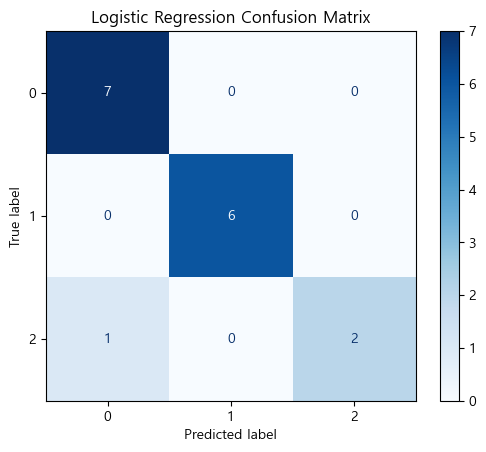

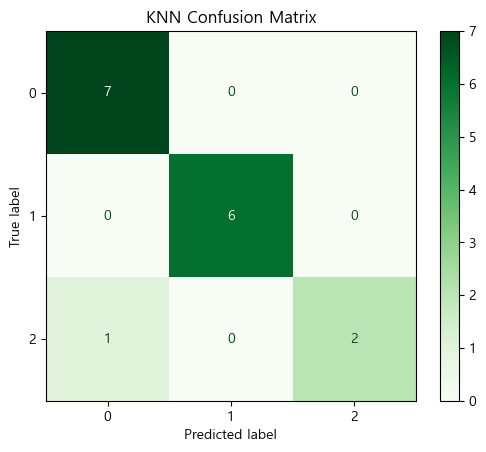

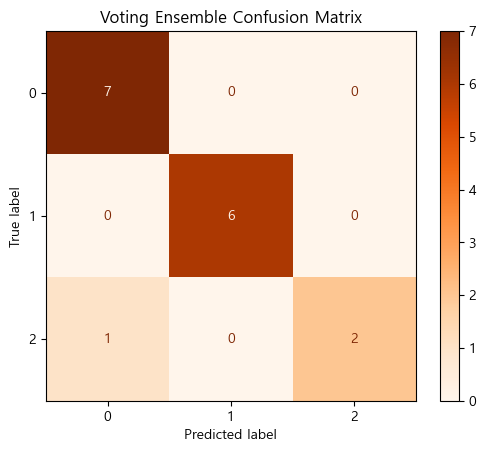

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay

# 로지스틱회귀
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_lr_scaled,
    cmap='Blues'
)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# 최근접이웃    
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_knn,
    cmap='Greens'
)
plt.title("KNN Confusion Matrix")
plt.show()

# 앙상블
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_voting,
    cmap='Oranges'
)
plt.title("Voting Ensemble Confusion Matrix")
plt.show()
